# Regression Week 2: Multiple Regression (Gradient Descent)

In this notebook, we will cover estimating multiple regression weights via gradient descent. You will:

* Compute the derivative of the regression weights with respect to a single feature.
* Write a gradient descent function to compute the regression weights given an initial weight vector, step size, and tolerance.
* Use the gradient descent function to estimate regression weights for multiple features
* Write a predict_output() function. This function uses the weights obtained from gradient descent to predict the output for any feature we are interested in predicting (in this case, house price).

## Importing Libraries

In [238]:
import os
import zipfile
from math import sqrt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

## Unzipping files with house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [239]:
# Put files in current direction into a list
files_list = [f for f in os.listdir('.') if os.path.isfile(f)]

In [240]:
# Filenames of unzipped files
unzip_files = ['kc_house_train_data.csv','kc_house_test_data.csv', 'kc_house_data.csv']

In [241]:
# If upzipped file not in files_list, unzip the file
for filename in unzip_files:
    if filename not in files_list:
        zip_file = filename + '.zip'
        zip = zipfile.ZipFile(zip_file)
        zip.extractall()
        zip.close

Loading Sales data, Sales training data, and Sales test data

In [242]:
# Dictionary with the correct dtypes for the DataFrame columns
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 
              'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 
              'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':str, 
              'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 
              'id':str, 'sqft_lot':int, 'view':int}

In [243]:
# Loading sales data, sales training data, and test_data into DataFrames
sales = pd.read_csv('kc_house_data.csv', dtype = dtype_dict)
train_data = pd.read_csv('kc_house_train_data.csv', dtype = dtype_dict)
test_data = pd.read_csv('kc_house_test_data.csv', dtype = dtype_dict)

In [244]:
# Looking at head of training data DataFrame
train_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Convert to DataFrame data to np matrix and np array

Now, we will write a function that will accept a DataFrame, a list of features (e.g. ['sqft_living', 'bedrooms']), and an target feature e.g. ('price'). This function will return two things:
* A numpy matrix whose columns are the desired features plus a constant column (this is how we create an 'intercept')
* A numpy array containing the values of the output

In [245]:
def get_numpy_data(input_df, features, output):
    
    input_df['constant'] = 1.0 # Adding column 'constant' to input DataFrame with all values = 1.0
    features = ['constant'] + features # Adding constant' to List of features

    feature_matrix = input_df.as_matrix(columns=features) # Convert DataFrame w/ columns in features list in np.ndarray
    output_array = input_df[output].values # Convert column with output feature into np.array
    
    return(feature_matrix, output_array)

## Predicting output given regression weights

Suppose we had the weights [1.0, 1.0] and the features [1.0, 1180.0] and we wanted to compute the predicted output 1.0\*1.0 + 1.0\*1180.0 = 1181.0 this is the dot product between these two arrays. If they're numpy arrays, we can use np.dot() to compute this. With this in mind, write the predict_output function to compute the predictions for an entire matrix of features given the matrix and the weights.

In [246]:
def predict_output(feature_matrix, weights):
    predictions = np.dot(feature_matrix, weights)
    return predictions

## Computing the Derivative

The cost function is the sum over the data points of the squared difference between an observed output and a predicted output. We can write the squared difference between the observed output and predicted output for a single point as follows:

(w[0]\*[CONSTANT] + w[1]\*[feature_1] + ... + w[i] \*[feature_i] + ... +  w[k]\*[feature_k] - output)^2

Where we have k features and a constant. So the derivative with respect to weight w[i] is:

2\*(w[0]\*[CONSTANT] + w[1]\*[feature_1] + ... + w[i] \*[feature_i] + ... +  w[k]\*[feature_k] - output)\* [feature_i]

The term inside the paranethesis is just the error (difference between prediction and output). So we can re-write this as:

2\*error\*[feature_i]

That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors.

With this in mind, complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).

In [247]:
def feature_derivative(errors, feature):
    derivative = 2.0*np.dot(errors, feature)
    return derivative

## Gradient Descent

Now, we will write a function that performs gradient descent. The basic steps are as follows. Given a starting point, we update the current weights by moving in the negative gradient direction (sinxw we're trying to *minimize* the cost function). 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. We define this by requiring that the magnitude (length) of the gradient vector to be smaller than a fixed 'tolerance'.

In the gradient descent function below, for each step in the gradient descent we update the weight for each feature befofe computing our stopping criteria.

In [248]:
def regression_gradient_descent(feature_matrix, output, initial_weights, step_size, tolerance):
    
    converged = False 
    weights = np.array(initial_weights) # Initializing the weights to be the initial weights
    
    while not converged:
        
        predictions = predict_output(feature_matrix, weights) # Finding predicted output w/ weights and feature_matrix
        
        errors = predictions - output # Computing error of predicted output and actual output for each data point
        
        gradient_sum_squares = 0 # initialize the gradient sum of squares
        
        # While we haven't reached the tolerance, update the weight of each feature
        # Looping over each feature
        for i in range(len(weights)): # loop over each weight

            der_feat_i = feature_derivative(errors, feature_matrix[:,i]) # Cost function derivative for feature i
            
            gradient_sum_squares += der_feat_i**2.0 # Add derivative^2 to grad. magnitude (for assessing convergence)
            
            weights[i] = weights[i] - step_size*der_feat_i # Update weight[i] by subtr. step_size * der. weight[i]
            
        # Compute square-root of gradient sum of squares to get the gradient magnigude:
        gradient_magnitude = sqrt(gradient_sum_squares)
        
        if gradient_magnitude < tolerance:
            converged = True
        
    return(weights)

A few things to note before we run the gradient descent. Since the gradient is a sum over all the data points and involves a product of an error and a feature the gradient itself will be very large since the features are large (squarefeet) and the output is large (prices). So while you might expect "tolerance" to be small, small is only relative to the size of the features. 

For similar reasons the step size will be much smaller than you might expect but this is because the gradient has such large values.

## Model 1: Running Gradient Descent as Simple Regression

Model 1: Running gradient descent with 1 feature: 'sqft_living'. The goal is to predict the feature 'price'.
The following cell sets of the feature list, the output feature, the feature matrix and output vector, the initial weights, the step_size, and the tolerane for the first model.

In [249]:
simple_features = ['sqft_living']
my_output = 'price'
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
initial_weights = np.array([-47000., 1.])
step_size = 7e-12
tolerance = 2.5e7

Next, run gradient descent with the above parameters to determine the weights of each feature.

In [250]:
weights_model_1 = regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, tolerance)

**Quiz Question: What is the value of the weight for sqft_living -- the second element of ‘simple_weights’ (rounded to 1 decimal place)?**

In [251]:
round(weights_model_1[1], 1)

281.9

Use newly estimated weights and predict_output() function to compute the predictions on the TEST data.

In [252]:
# First, from test data, create a feature matrix and output vector
(test_model_1_feature_matrix, test_output_model_1) = get_numpy_data(test_data, simple_features, my_output)

Now, compute predictions using test_model_1_feature_matrix and weights from above.

In [253]:
test_model_1_predictions =  predict_output(test_model_1_feature_matrix, weights_model_1)

**Quiz Question: What is the predicted price for the 1st house in the TEST data set for model 1 (round to nearest dollar)?**

In [254]:
round(test_model_1_predictions[0] , 0)

356134.0

Now, with the predictions on test data, compute the RSS (Residual Sum of Squares) on the test data set.

In [255]:
RSS_test_model_1 = sum( (test_model_1_predictions-test_data['price'].values)**2.0 )

## Comparing Gradient Descent with Sklearn Library

** Now, using Python sklearn Library to find weights and compare them to gradient descent algorithm **

In [256]:
# Creating feature matrix with 'sqft_living' feature and output vector with 'price' feature
X_model_1 = train_data[ ['sqft_living'] ]
y_model_1 = train_data['price']

In [257]:
# Creating a LinearRegression Object. Then, performing linear regression on feature matrix and output vector
lin_reg_model_1 = LinearRegression()
lin_reg_model_1.fit(X_model_1, y_model_1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [258]:
# Creating x-vector for plotting. Then, defining line with weights from gradient descent and sklearn
x_vect_simple_reg = np.arange(0,14000+1,1)
y_model_1_grad_desc = weights_model_1[0] + weights_model_1[1]*x_vect_simple_reg
y_model_1_sklearn = lin_reg_model_1.intercept_ + lin_reg_model_1.coef_[0]*x_vect_simple_reg

** Figure below shows that weights from Gradient Descent and Sklearn library are in good agreement **

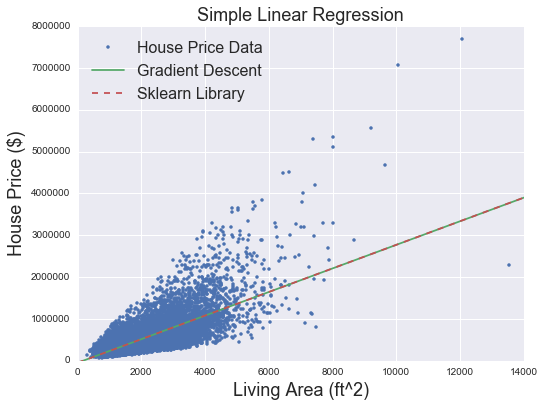

In [259]:
plt.figure(figsize=(8,6))
plt.plot(train_data['sqft_living'], train_data['price'],'.',label= 'House Price Data')
plt.hold(True)
plt.plot(x_vect_simple_reg, y_model_1_grad_desc, label= 'Gradient Descent')
plt.plot(x_vect_simple_reg, y_model_1_sklearn, '--' , label= 'Sklearn Library')
plt.hold(False)
plt.legend(loc='upper left', fontsize=16)
plt.xlabel('Living Area (ft^2)', fontsize=18)
plt.ylabel('House Price ($)', fontsize=18)
plt.title('Simple Linear Regression', fontsize=18)
plt.axis([0.0, 14000.0, 0.0, 8000000.0])
plt.show()

## Running a multiple regression

Now we will use more than one actual feature. Use the following code to produce the weights for a second model with the following parameters:

In [260]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
initial_weights = np.array([-100000., 1., 1.])
step_size = 4e-12
tolerance = 1e9

Use the above parameters to estimate the model weights. Record these values for your quiz.

In [261]:
weights_2_deat_lin_reg = regression_gradient_descent(feature_matrix, output, 
                                                     initial_weights, step_size, tolerance)

Use your newly estimated weights and the predict_output function to compute the predictions on the TEST data. Don't forget to create a numpy array for these features from the test set first!

In [262]:
(test_2_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)
test_2_feat_predictions =  predict_output(test_2_feature_matrix, weights_2_deat_lin_reg)

**Quiz Question: What is the predicted price for the 1st house in the TEST data set for model 2 (round to nearest dollar)?**

In [263]:
round(test_2_feat_predictions[0] , 0)

366651.0

What is the actual price for the 1st house in the test data set?

In [264]:
test_data['price'][0]

310000.0

## Comparing Model 1 (one feature) vs Model 2 (multiple features)

**Quiz Question: Which estimate was closer to the true price for the 1st house on the Test data set, model 1 or model 2?**

In [265]:
diff_model_1_house_1_price = abs(test_model_1_predictions[0] - test_data['price'][0])
diff_model_2_house_1_price = abs(test_2_feat_predictions[0] - test_data['price'][0])
if diff_model_1_house_1_price < diff_model_2_house_1_price:
    print 'Model 1 closer to true price for 1st house'
else:
    print 'Model 2 closer to true price for 1st house'

Model 1 closer to true price for 1st house


Now use your predictions and the output to compute the RSS for model 2 on TEST data.

In [266]:
RSS_test_model_2 = sum( (test_2_feat_predictions-test_data['price'].values)**2.0 )
print RSS_test_model_2

2.7026344363e+14


**Quiz Question: Which model (1 or 2) has lowest RSS on all of the TEST data? **

In [267]:
if RSS_test_model_1 < RSS_test_model_2:
    print 'RSS lower for Model 1'
else:
    print 'RSS lower for Model 2'

RSS lower for Model 2
